In [1]:
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector,Operator
import random
import matplotlib.pyplot as plt

import numpy as np
import time
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize,OptimizeResult
from qiskit_algorithms.optimizers import SPSA

backend = AerSimulator()

In [2]:
I = np.array([[1,0],
              [0,1]])
X = np.array([[0,1],
              [1,0]])
Z = np.array([[1,0],
              [0,-1]])
H_op = [(1, 'IIII'),
        (0.25, 'IIXZ'),
        (0.5, 'ZIZI'), 
        (0.10, 'ZZII')]

m = (1*np.kron(I,np.kron(I,np.kron(I,I)))
   +0.25*np.kron(I,np.kron(I,np.kron(X,Z)))
   +0.5*np.kron(Z,np.kron(I,np.kron(Z,I)))
   +0.10*np.kron(Z,np.kron(Z,np.kron(I,I))))

In [3]:
nb_qubits = 4
def U_b(nb_qubits):
    circ = QuantumCircuit(nb_qubits)
    for q in range(nb_qubits):
        circ.h(q)
    return circ
U=U_b(nb_qubits)
b = np.array(Statevector(U))
def Hamiltonian(nb_qubits,m):
    Ub = np.array(Operator(U_b(nb_qubits)))
    z= np.array([[1,0],
                 [0,-1]])
    I=np.array([[1,0],
                 [0,1]])
    def tensor(i,j,k,l):
        return np.kron(i,np.kron(j,np.kron(k,l)))
    M1 = (Ub@tensor(z,I,I,I)@np.conj(Ub.T)
        + Ub@tensor(I,z,I,I)@np.conj(Ub.T)
        + Ub@tensor(I,I,z,I)@np.conj(Ub.T)
        + Ub@tensor(I,I,I,z)@np.conj(Ub.T))

    M = 0.5*np.conj(m.T)@(tensor(I,I,I,I) - M1/nb_qubits)@m

    return M

A = Hamiltonian(nb_qubits,m)

pauli_op = SparsePauliOp.from_operator(A) 

coeffs1 = np.real(pauli_op.coeffs)
op_strings1 = [str(op) for op in pauli_op.paulis]
print(op_strings1)
print(coeffs1)
print(len(op_strings1))

['IIII', 'IIIX', 'IIIZ', 'IIXI', 'IIXZ', 'IXII', 'IXXZ', 'IZZI', 'IZZX', 'XIII', 'XIXZ', 'XZZI', 'YIYZ', 'ZIYY', 'ZIZI', 'ZIZX', 'ZIZZ', 'ZXZI', 'ZZII', 'ZZIX', 'ZZIZ', 'ZZXI', 'ZZXZ']
[ 0.66125   -0.1496875 -0.0625    -0.1028125  0.25      -0.1628125
 -0.0625     0.05      -0.0125    -0.1003125 -0.0625     0.0125
  0.03125   -0.03125    0.5       -0.125     -0.03125   -0.125
  0.1       -0.025     -0.00625   -0.025      0.025    ]
23


[5.54071495e-01 7.12368930e-01 6.47160263e-01 5.89980742e-01
 1.06058867e-01 9.63864948e-01 3.75947181e-01 3.65942308e-01
 3.84312518e-01 1.25804976e-01 8.25588678e-04 7.39802712e-01
 5.27981727e-01 9.83962215e-01 2.74781084e-02 5.88638716e-01
 4.07166127e-01 6.80469296e-01 1.74373111e-01 1.45889332e-01
 9.74386739e-01 7.28734560e-01 9.71314165e-01 8.98026138e-01
 8.35660901e-01 2.18118907e-01 4.75834362e-01 3.82487621e-01
 4.38124948e-01 8.40285758e-01 9.96716393e-01 5.24677548e-02
 5.57871827e-01 5.43963607e-01 2.19112345e-01 1.71079915e-01
 2.61129227e-01 7.98602619e-01 5.38300351e-01 5.74455400e-01
 6.39354882e-01 3.58951919e-01 6.40244465e-01 7.11873020e-01
 5.58941706e-01 6.57511256e-01 2.36631134e-01 8.42027481e-01
 3.38742110e-01 9.71471556e-01 7.58444733e-01 1.74009040e-01
 5.77698609e-01 5.05580392e-01 4.48888638e-01 9.16652478e-01
 5.28055813e-01 3.74207148e-01 2.15841675e-01 5.28919550e-01
 3.18532829e-01 6.44294062e-01 3.97465226e-01 4.39750587e-01
 7.98095550e-01 5.658953

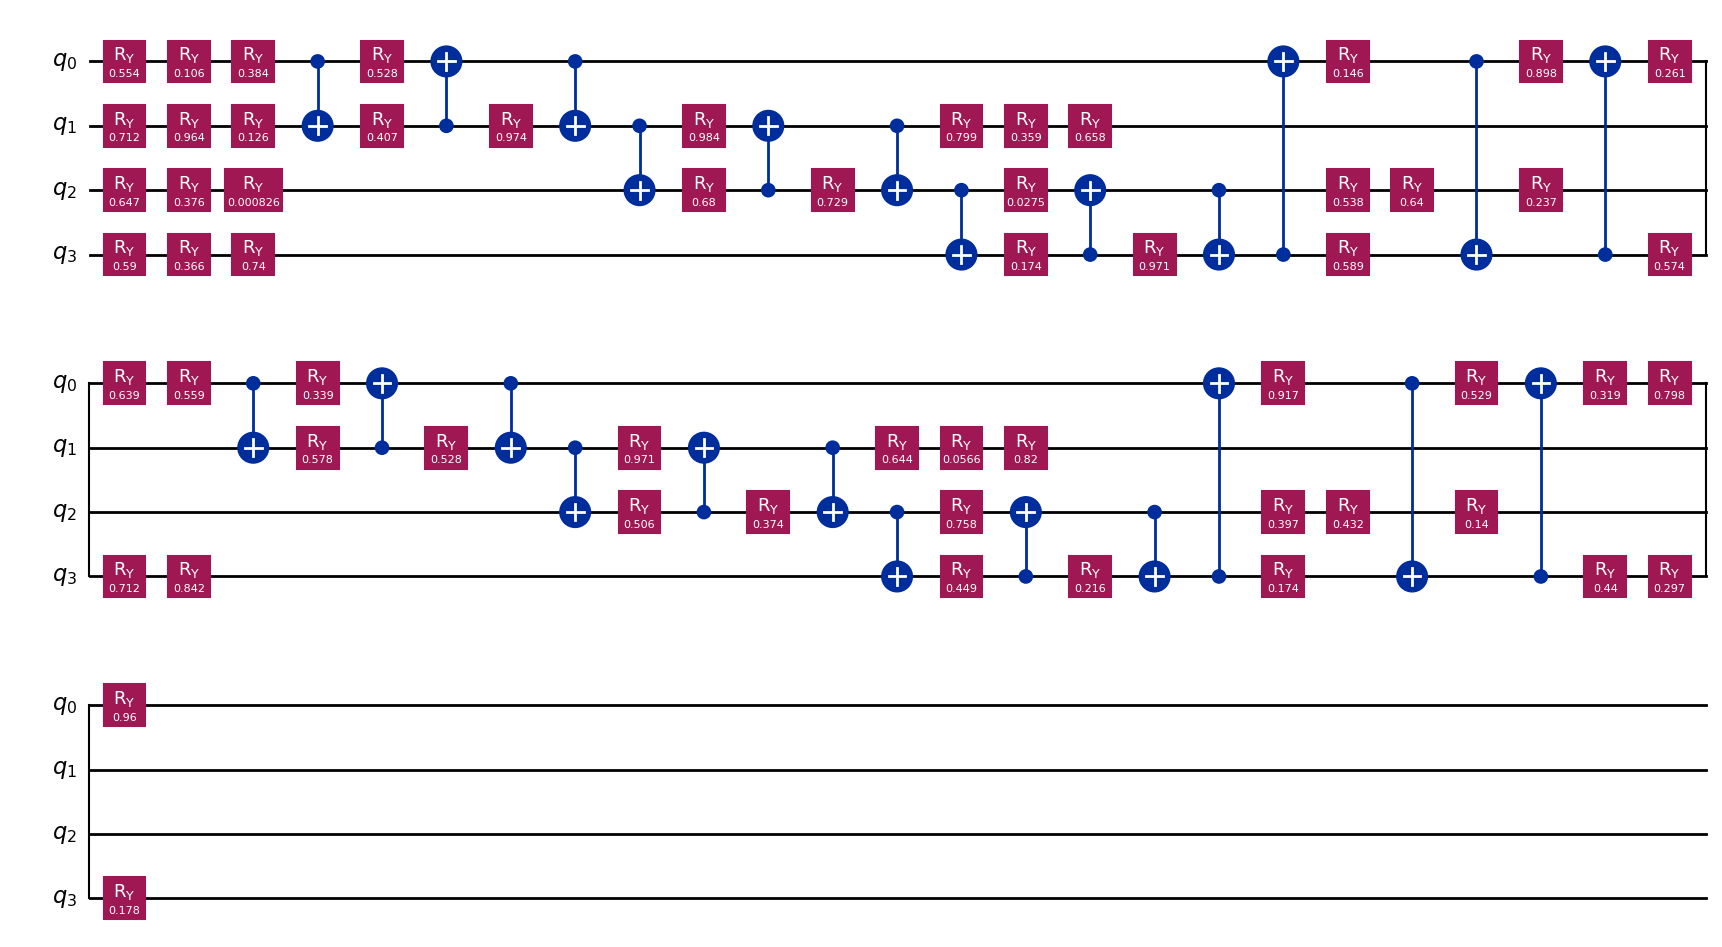

In [4]:
def ansatz(parameters):
    qc = QuantumCircuit(N)
    for d in range(depth):
        param1=parameters[d*9*N:(d+1)*(9*N)]
        for q in range(N):
            qc.ry(param1[q],qubits[q])
            qc.ry(param1[q+N],qubits[q])
            qc.ry(param1[q+2*N],qubits[q])
        # qc.barrier()
        for q in range(N):
            qc.cx(qubits[q], qubits[(q+1)% N])
            qc.ry(param1[q+3*N],qubits[q])
            qc.ry(param1[q+4*N],qubits[(q+1)% N])
            qc.cx(qubits[(q+1)% N], qubits[q])
            qc.ry(param1[q+5*N],qubits[(q+1)% N])
            qc.cx(qubits[q], qubits[(q+1)% N])
        # qc.barrier()
        if d==depth-1:
            for q in range(N):
                qc.ry(param1[q+6*N],qubits[q])
                qc.ry(param1[q+7*N],qubits[q])
                qc.ry(param1[q+8*N],qubits[q])
        # qc.barrier()
    # qc.h(list(range(4)))
    return qc


nb_qubits = 4
depth = 2
qubits=list(range(nb_qubits))
N=len(qubits)
nb_params=int(9*N*depth)

parameters = np.array([random.random() for _ in range(0, nb_params)])
print(parameters)
ansatz(parameters).draw("mpl")


In [5]:
coeffs = [coeffs1[k:k+4] for k in range(0,len(coeffs1),4)]
op_strings = [op_strings1[k:k+4] for k in range(0,len(op_strings1),4)]
op_strings

[['IIII', 'IIIX', 'IIIZ', 'IIXI'],
 ['IIXZ', 'IXII', 'IXXZ', 'IZZI'],
 ['IZZX', 'XIII', 'XIXZ', 'XZZI'],
 ['YIYZ', 'ZIYY', 'ZIZI', 'ZIZX'],
 ['ZIZZ', 'ZXZI', 'ZZII', 'ZZIX'],
 ['ZZIZ', 'ZZXI', 'ZZXZ']]

In [6]:

def opstr_to_meas_circ(op_str,ancilla_reg,qreg):

    circs = []
    for k in range(len(op_str)):
        qc = QuantumCircuit(ancilla_reg,qreg)
        for idx, item in enumerate(op_str[k]):
            if item == 'X':
                qc.cx(ancilla_reg[k],qreg[nb_qubits-idx-1])
            elif item == 'Y':
                qc.cy(ancilla_reg[k],qreg[nb_qubits-idx-1])
            elif item == 'Z':
                qc.cz(ancilla_reg[k],qreg[nb_qubits-idx-1])
        circs.append(qc)
    return circs
# opstr_to_meas_circ(op_strings,ancilla,y)[1].draw('mpl')

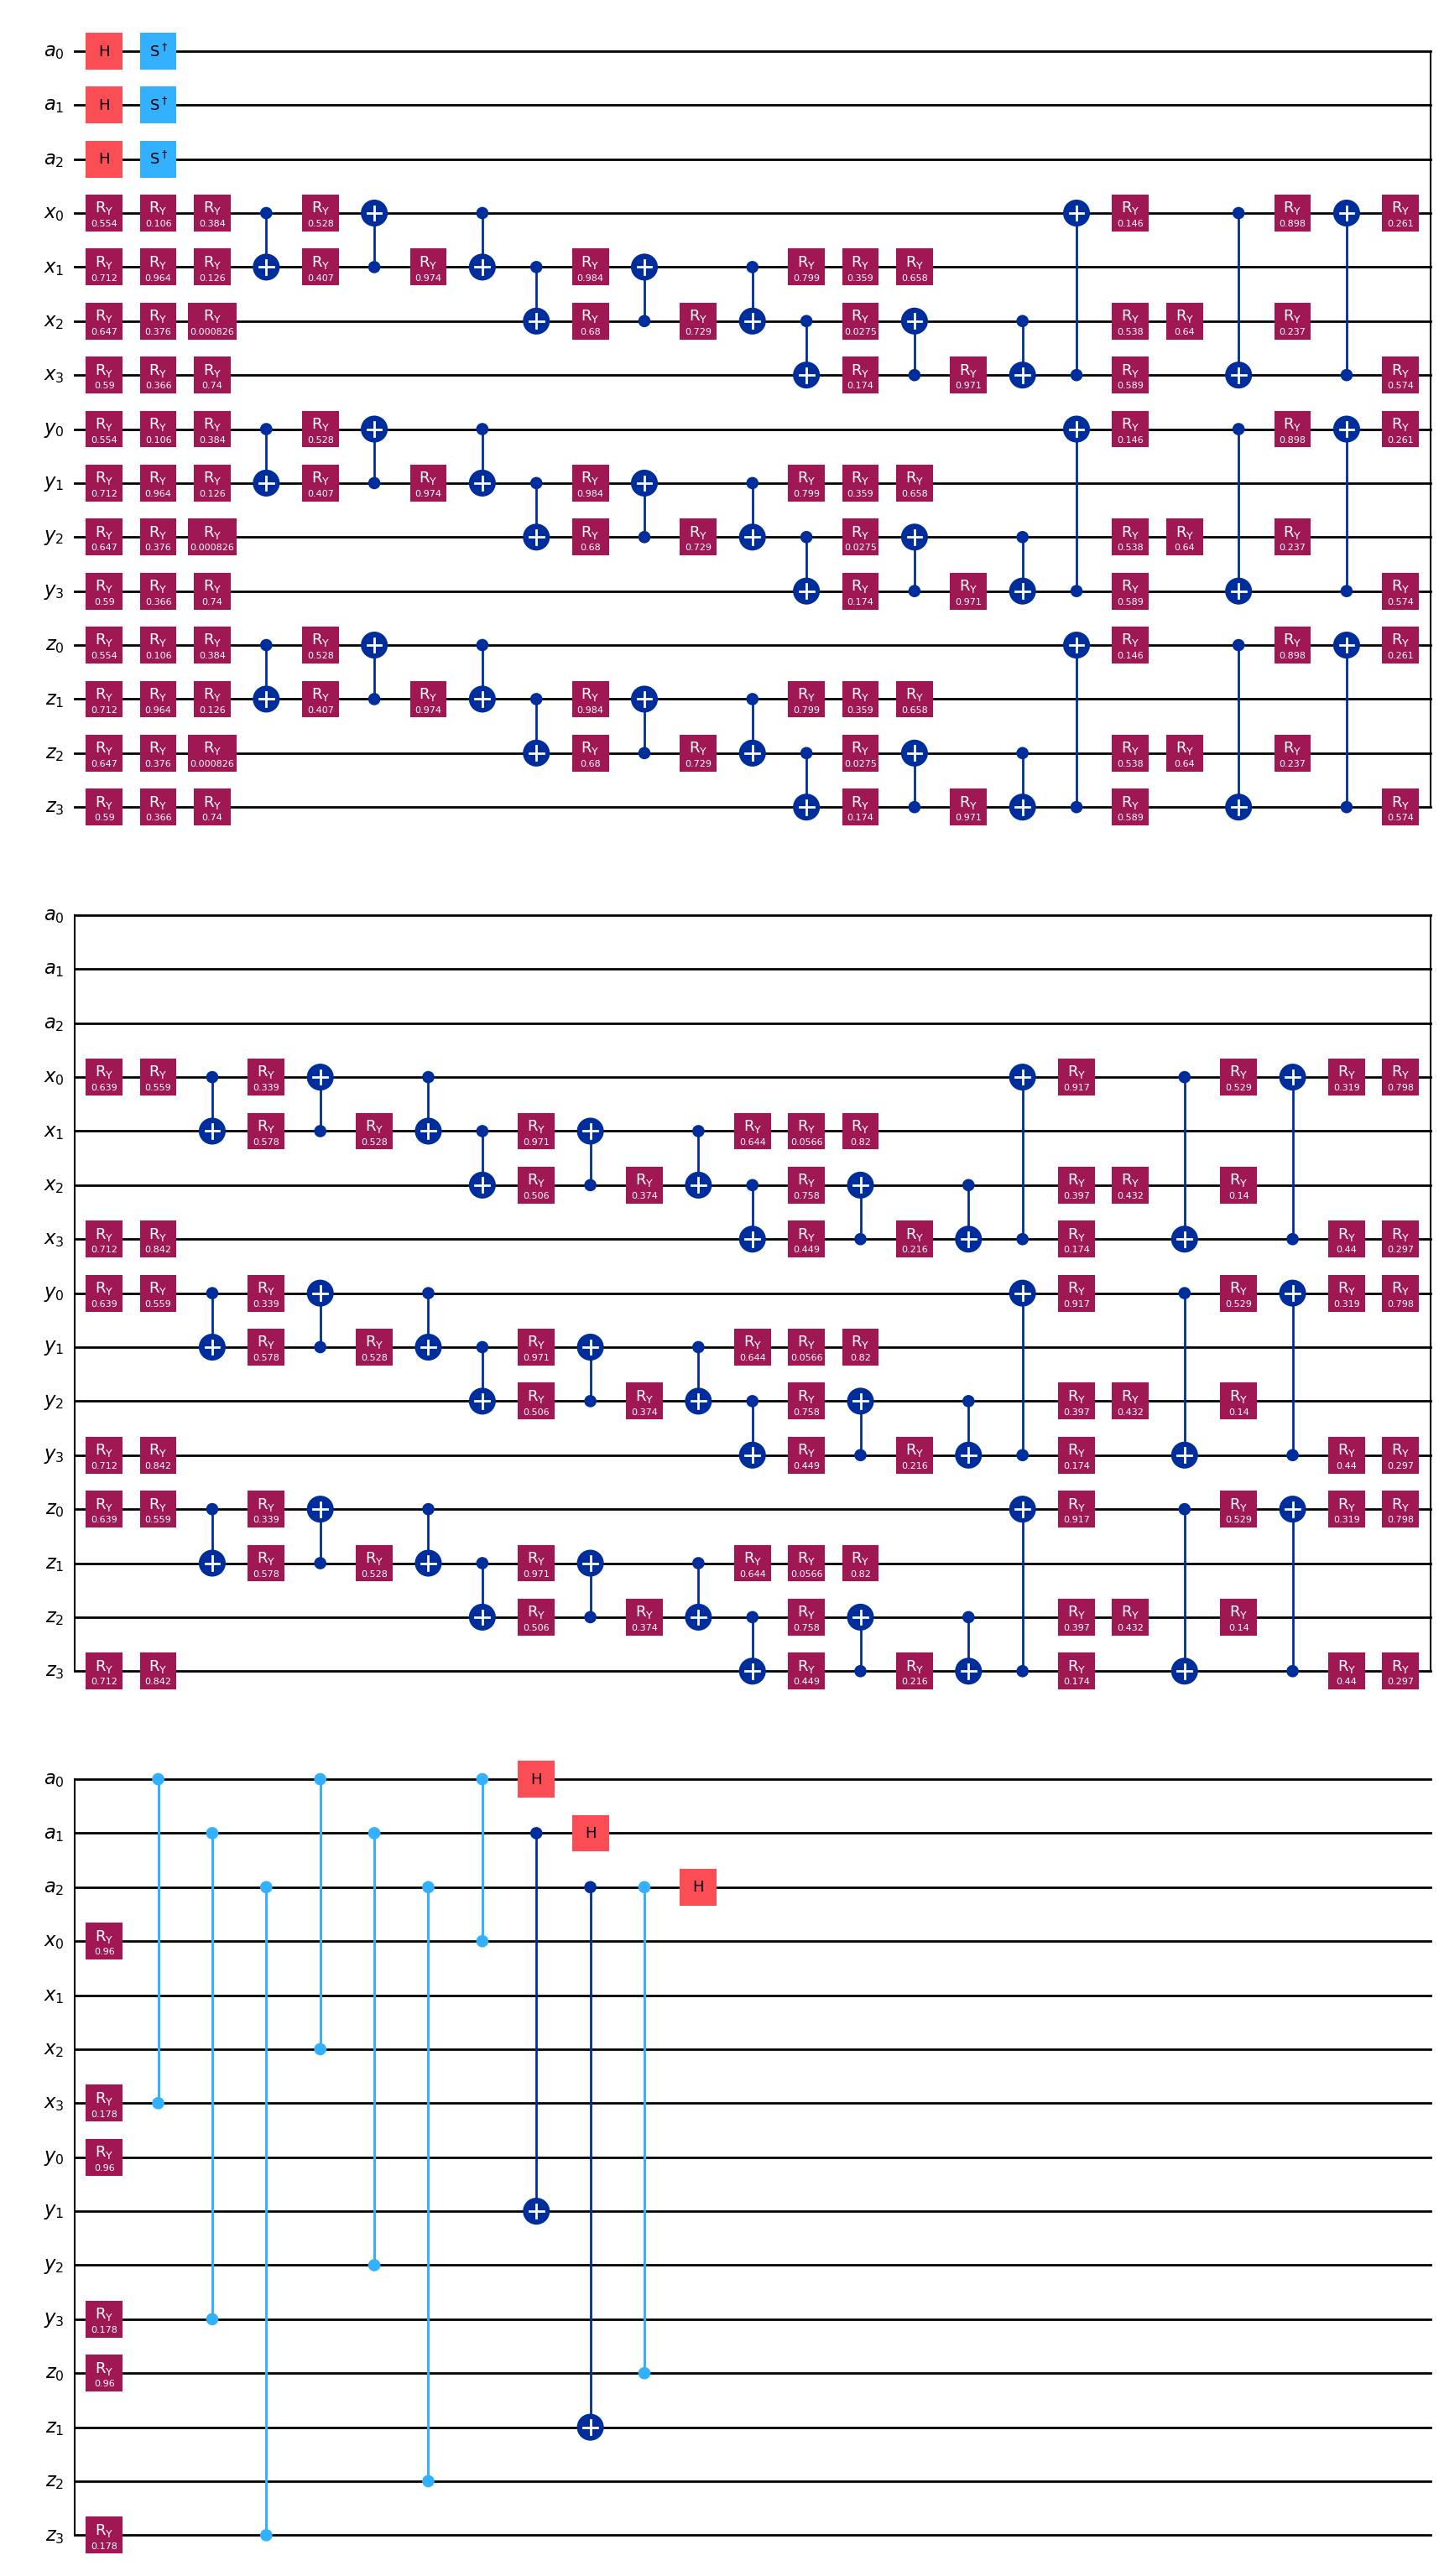

In [7]:

def circs(parameters,op_strings,part = None):
    
    ans = ansatz(parameters)
    Cicr_list = []
    for k in range(len(op_strings)):
        N_ops = len(op_strings[k])
        x = QuantumRegister(nb_qubits, name = 'x')
        y = QuantumRegister(nb_qubits, name = 'y')
        z = QuantumRegister(nb_qubits, name = 'z')
        t = QuantumRegister(nb_qubits, name = 't')
        
        if N_ops == 4:
            ancillar = QuantumRegister(N_ops,  name = 'a')
            qc = QuantumCircuit(ancillar,x,y,z,t)
            qc.h(ancillar)
            if part == 'im':
                qc.sdg(ancillar)
            qc = qc.compose(ans,[x[0],x[1],x[2],x[3]])
            qc = qc.compose(ans,[y[0],y[1],y[2],y[3]])
            qc = qc.compose(ans,[z[0],z[1],z[2],z[3]])
            qc = qc.compose(ans,[t[0],t[1],t[2],t[3]])
        
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, x)[0],[ancillar[0],ancillar[1],ancillar[2],ancillar[3],x[0],x[1],x[2],x[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, y)[1],[ancillar[0],ancillar[1],ancillar[2],ancillar[3],y[0],y[1],y[2],y[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, z)[2],[ancillar[0],ancillar[1],ancillar[2],ancillar[3],z[0],z[1],z[2],z[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, t)[3],[ancillar[0],ancillar[1],ancillar[2],ancillar[3],t[0],t[1],t[2],t[3]])

            qc.h(ancillar)
            
            Cicr_list.append(qc)
        elif N_ops == 3:
            ancillar = QuantumRegister(N_ops,  name = 'a')
            qc = QuantumCircuit(ancillar,x,y,z)
            qc.h(ancillar)
            if part == 'im':
                qc.sdg(ancillar)
            qc = qc.compose(ans,[x[0],x[1],x[2],x[3]])
            qc = qc.compose(ans,[y[0],y[1],y[2],y[3]])
            qc = qc.compose(ans,[z[0],z[1],z[2],z[3]])

            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, x)[0],[ancillar[0],ancillar[1],ancillar[2],x[0],x[1],x[2],x[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, y)[1],[ancillar[0],ancillar[1],ancillar[2],y[0],y[1],y[2],y[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, z)[2],[ancillar[0],ancillar[1],ancillar[2],z[0],z[1],z[2],z[3]])
            qc.h(ancillar)

            Cicr_list.append(qc)
        elif N_ops == 2:
            ancillar = QuantumRegister(N_ops,  name = 'a')
            qc = QuantumCircuit(ancillar,x,y)
            qc.h(ancillar)
            if part == 'im':
                qc.sdg(ancillar)
            qc = qc.compose(ans,[x[0],x[1],x[2],x[3]])
            qc = qc.compose(ans,[y[0],y[1],y[2],y[3]])

            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, x)[0],[ancillar[0],ancillar[1],x[0],x[1],x[2],x[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, y)[1],[ancillar[0],ancillar[1],y[0],y[1],y[2],y[3]])
            qc.h(ancillar)
        elif N_ops == 1:
            ancillar = QuantumRegister(N_ops,  name = 'a')
            qc = QuantumCircuit(ancillar,x,y)
            
            qc.h(ancillar)
            if part == 'im':
                qc.sdg(ancillar)
            qc = qc.compose(ans,[x[0],x[1],x[2],x[3]])
            qc = qc.compose(opstr_to_meas_circ(op_strings[k],ancillar, x)[0],[ancillar[0],x[0],x[1],x[2],x[3]])
            qc.h(ancillar)

            Cicr_list.append(qc)
    return Cicr_list
circs(parameters,op_strings,part = 'im')[-1].draw('mpl')

In [8]:
shots = 100000
def cost(parameters):
    Circs = circs(parameters,op_strings,part='re')

    Average = 0
    for k in range(len(op_strings)):
        N_ops = len(op_strings[k])
        x = QuantumRegister(nb_qubits, name = 'x')
        y = QuantumRegister(nb_qubits, name = 'y')
        z = QuantumRegister(nb_qubits, name = 'z')
        t = QuantumRegister(nb_qubits, name = 't')
        
        if N_ops == 4:
            ancillar = QuantumRegister(N_ops, name = 'a')
            c = ClassicalRegister(N_ops)
            
            qc = QuantumCircuit(ancillar,x,y,z,t,c)
            qc = qc.compose(Circs[k], list(range( N_ops*(nb_qubits+1))))
            qc.measure(ancillar,c)

            job = backend.run(qc,shots = shots)
            result = job.result().get_counts() 
        
            for n in range(2**N_ops):
                state_str = str((bin(n)[2:].zfill(N_ops)))
                if not state_str in result.keys():
                    result[state_str] = 0

            avg = (coeffs[k][0]*(result['0000']-result['0001'])/(result['0000']+result['0001']) 
               + coeffs[k][1]*(result['0000']-result['0010'])/(result['0000']+result['0010']) 
               + coeffs[k][2]*(result['0000']-result['0100'])/(result['0000']+result['0100'])
              + coeffs[k][3]*(result['0000']-result['1000'])/(result['0000']+result['1000']))
            Average += avg
            
        elif N_ops == 3:

            ancillar = QuantumRegister(N_ops, name = 'a')
            c = ClassicalRegister(N_ops)
            
            qc = QuantumCircuit(ancillar,x,y,z,c)
            qc = qc.compose(Circs[k], list(range( N_ops*(nb_qubits+1))))
            qc.measure(ancillar,c)

            # qct2 = pm.run(qc2)
            job = backend.run(qc,shots = shots)
            result = job.result().get_counts() 
        
            for n in range(2**(N_ops)):
                state_str = str((bin(n)[2:].zfill(N_ops)))
                if not state_str in result.keys():
                    result[state_str] = 0
        
            
            avg = (coeffs[k][0]*(result['000']-result['001'])/(result['000']+result['001']) 
               + coeffs[k][1]*(result['000']-result['010'])/(result['000']+result['010']) 
               + coeffs[k][2]*(result['000']-result['100'])/(result['000']+result['100']))
            Average += avg
        elif N_ops == 2:

            ancillar = QuantumRegister(N_ops, name = 'a')
            c = ClassicalRegister(N_ops)
            
            qc = QuantumCircuit(ancillar,x,y,c)
            qc = qc.compose(Circs[k], list(range( N_ops*(nb_qubits+1))))
            qc.measure(ancillar,c)

            # qct2 = pm.run(qc2)
            job = backend.run(qc,shots = shots)
            result = job.result().get_counts() 
        
            for n in range(2**(N_ops)):
                state_str = str((bin(n)[2:].zfill(N_ops)))
                if not state_str in result.keys():
                    result[state_str] = 0
        
            
            avg = (coeffs[k][0]*(result['00']-result['01'])/(result['00']+result['01']) 
               + coeffs[k][1]*(result['00']-result['10'])/(result['00']+result['10']))
            Average += avg

        elif N_ops == 1:

            ancillar = QuantumRegister(N_ops, name = 'a')
            c = ClassicalRegister(N_ops)
            
            qc = QuantumCircuit(ancillar,x,c)
            qc = qc.compose(Circs[k], list(range( N_ops*(nb_qubits+1))))
            qc.measure(ancillar,c)

            # qct2 = pm.run(qc2)
            job = backend.run(qc,shots = shots)
            result = job.result().get_counts() 
        
            for n in range(2**(N_ops)):
                state_str = str((bin(n)[2:].zfill(N_ops)))
                if not state_str in result.keys():
                    result[state_str] = 0
        
            
            avg = (coeffs[k][0]*(result['0'] - result['1']))/shots
            Average += avg
    return Average 
# res = cost(parameters)
# res

In [9]:
ti = time.time()
def save(nfev, parameters, cost, learning_rate, trust_region):
    global Cost,Params
    Cost.append(cost)
    Params.append(parameters)
    print(nfev,cost)
Cost = []
Params = []
Optimizer = SPSA(maxiter = 302, callback = save)
Optimizer.minimize(cost, x0 = parameters)

tf = time.time()

t = tf - ti

print(t)

3 0.37541886252214757
6 0.37118352379923386
9 0.7629572574916319
12 1.0636104816536633
15 0.9735755836467305
18 0.7458546981075593
21 0.6030463483232995
24 0.5639243401412488
27 0.5515365678436808
30 0.5405951525492075
33 0.473583941100916
36 0.46929431259688176
39 0.39126880155311694
42 0.36201633619646295
45 0.3666656294262924
48 0.3737863690051716
51 0.3867624526689687
54 0.4400428695973096
57 0.34664691333228154
60 0.34629238954391905
63 0.7257763377237839
66 0.6625684908398116
69 0.6588696437282483
72 0.6994820035352081
75 0.6726171815331219
78 0.6088322819955149
81 0.4872334005650208
84 0.5644846531260943
87 0.48554961591654144
90 0.41004556903302547
93 0.3932602478910904
96 0.28979474496919333
99 0.2811548125245704
102 0.2509438577054895
105 0.2368804573972111
108 0.21375721176869247
111 0.23651054271187422
114 0.3163400688852661
117 0.3379190458579846
120 0.30934234660774756
123 0.2863054710997215
126 0.18831416787580132
129 0.17821648637495907
132 0.19984117612946659
135 0.168

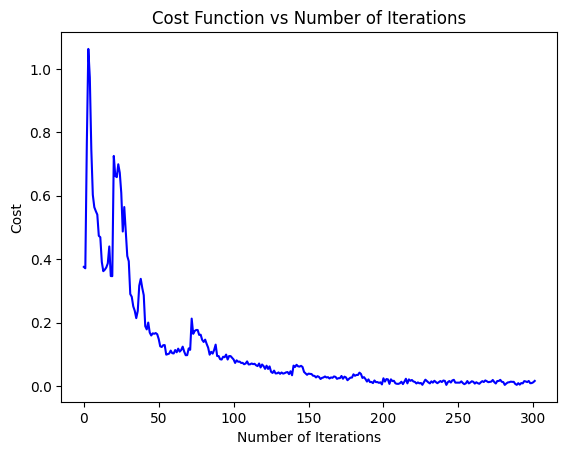

In [10]:
plt.plot(range(len(Cost)), Cost,'b')
# plt.axis([0, 1240, 0, 0.22])
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost Function vs Number of Iterations')
plt.show()

In [11]:
x_exact = np.linalg.solve(m,b)
x_exact = x_exact/np.linalg.norm(x_exact)

In [12]:

e = []
F =[ ]

norm_e = []
eps = []
for k in range(len(Params)):
    state = np.array(Statevector(ansatz(Params[k])))
    psi = np.dot(m,state)
    Psi = psi/np.linalg.norm(psi)
    norm = np.dot(Psi,b) 
    s = np.sign(np.dot(Psi,b))
    e.append(x_exact - s*state)

    f = abs(np.dot(x_exact,state))**2
    ep = np.linalg.norm(b - Psi*norm) 
    
    eps.append(ep)
    F.append(f)

for v in e:
    norm_e.append(np.linalg.norm(v))

Text(0.5, 0, 'Iteration')

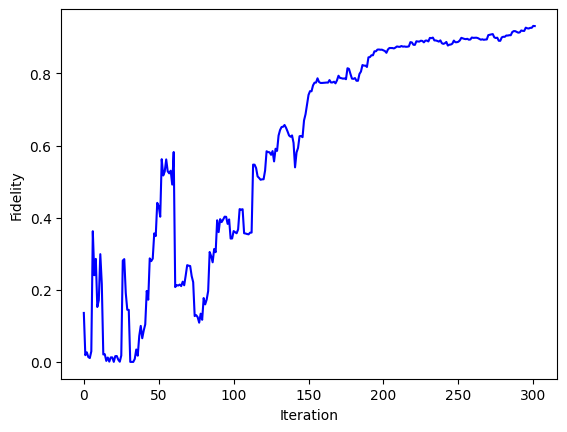

In [13]:
plt.plot(range(len(F)),F,'b')
# plt.axis([0, 100, 0, 0.0007])
plt.ylabel('Fidelity')
plt.xlabel('Iteration')



Text(0.5, 0, 'Iteration')

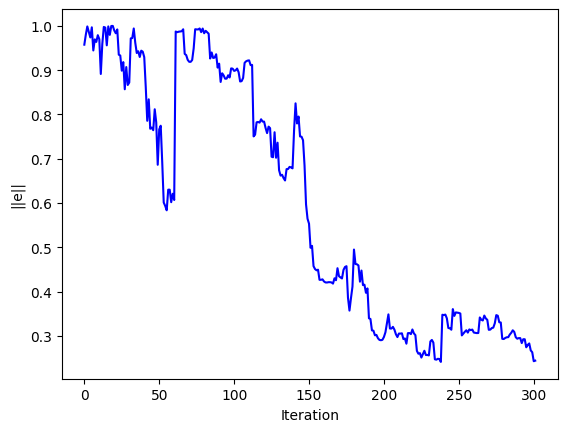

In [14]:
plt.plot(range(len(eps)),eps,'b')
# plt.axis([0, 100, 0, 0.0007])
plt.ylabel('||e||')
plt.xlabel('Iteration')

# plt.savefig('error3-Rotosolve')

In [15]:
X_opt  = np.array(Statevector(ansatz(Params[np.argmin(Cost)])))
psi = m@X_opt
psi = psi/np.linalg.norm(psi)


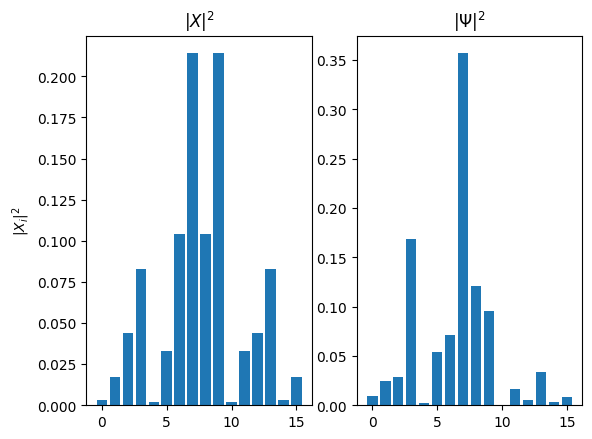

In [16]:
ax=plt.subplot(121)
ax.bar(range(len(x_exact)),abs(x_exact)**2)
plt.title('$|X|^2$')
plt.xlabel('')
plt.ylabel('$|X_i|^2$')
ax=plt.subplot(122)
ax.bar(range(len(X_opt)),abs(X_opt)**2)
plt.xlabel('')
# plt.ylabel('$|b_i|^2$')
plt.title('$|\\Psi|^2$')
plt.savefig('b-amplitude3-rotosolve')